In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score, precision_score, f1_score, classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [4]:
# Load and preprocess dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
columns = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
df = pd.read_csv(url, header=None, names=columns)
df["Diagnosis"] = df["Diagnosis"].map({"M": 1, "B": 0})
df.drop(columns=["ID"], inplace=True)
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

In [5]:
# 80/20 split: training for nested CV, testing held out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
# Define models and hyperparameters
models = {
    "SVM": (SVC(probability=True, class_weight='balanced'), 
            {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}),

    "KNN": (KNeighborsClassifier(), 
            {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}),

    "DecisionTree": (DecisionTreeClassifier(class_weight='balanced'), 
                     {'max_depth': [3, 5, 7, 10], 'criterion': ['gini', 'entropy']}),

    "LogisticRegression": (LogisticRegression(class_weight='balanced', max_iter=1000), 
                           {'C': [0.1, 1, 10, 100]})
}

# Nested CV setup
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Track best model
best_model_name, best_score, best_pipeline, best_param_grid = None, 0, None, None

# Evaluate each model using nested CV
for model_name, (model, param_grid) in models.items():
    steps = []
    if model_name in ["SVM", "KNN", "LogisticRegression"]:
        steps.append(('scaler', StandardScaler()))
    steps.append((model_name.lower(), model))
    
    pipeline = Pipeline(steps)
    full_param_grid = {f"{model_name.lower()}__{k}": v for k, v in param_grid.items()}

    grid_search = GridSearchCV(pipeline, full_param_grid, cv=inner_cv, scoring='recall')
    nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='recall')
    mean_recall = nested_scores.mean()

    print(f"{model_name} Nested CV Recall: {mean_recall:.4f} ± {nested_scores.std():.4f}")

    if mean_recall > best_score:
        best_model_name = model_name
        best_score = mean_recall
        best_pipeline = pipeline
        best_param_grid = full_param_grid

print(f"\nBest Model: {best_model_name} with CV Recall: {best_score:.4f}")

# Final model: retrain on full training set with best hyperparameters
final_grid = GridSearchCV(best_pipeline, best_param_grid, cv=inner_cv, scoring='recall')
final_grid.fit(X_train, y_train)
final_model = final_grid.best_estimator_

# Test evaluation
y_test_pred = final_model.predict(X_test)
test_recall = recall_score(y_test, y_test_pred)
print(f"\nFinal Test Recall: {test_recall:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

SVM Nested CV Recall: 0.9588 ± 0.0353
KNN Nested CV Recall: 0.9235 ± 0.0440
DecisionTree Nested CV Recall: 0.8941 ± 0.0660
LogisticRegression Nested CV Recall: 0.9529 ± 0.0235

Best Model: SVM with CV Recall: 0.9588

Final Test Recall: 0.9524

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        72
           1       0.89      0.95      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



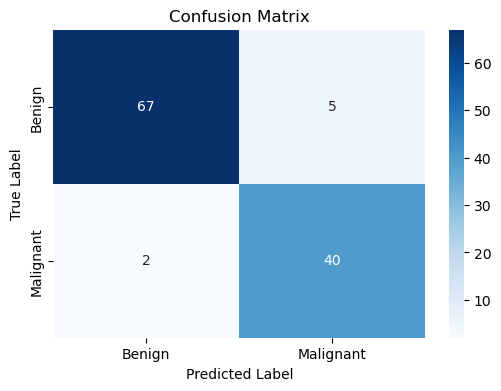

In [7]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

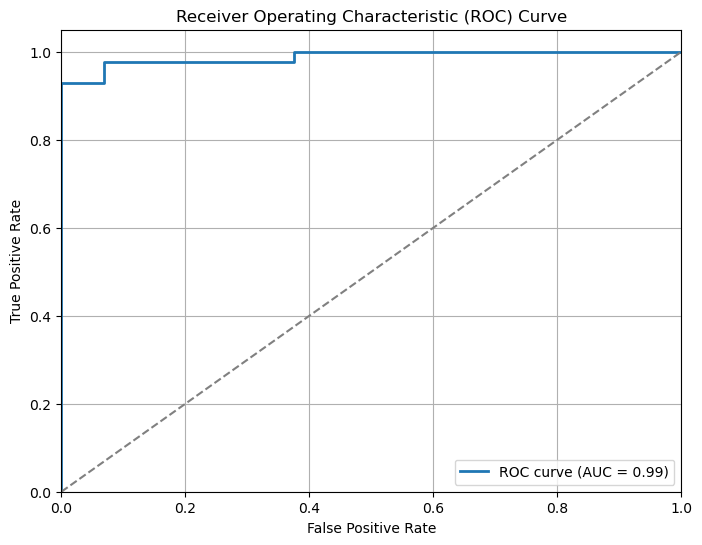

In [10]:
# Get predicted probabilities for ROC curve
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
else:
    # For models like SVM without predict_proba, use decision_function and normalize
    y_test_proba = final_model.decision_function(X_test)
    y_test_proba = (y_test_proba - y_test_proba.min()) / (y_test_proba.max() - y_test_proba.min())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

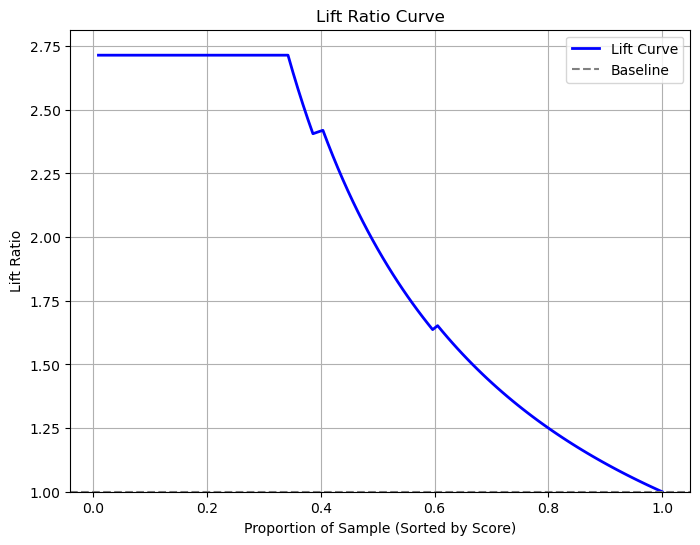

In [11]:
# Sort test probabilities and corresponding true labels in descending order
sorted_indices = np.argsort(y_test_proba)[::-1]
sorted_y = np.array(y_test)[sorted_indices]

# Compute cumulative gain (recall) curve
cumulative_positives = np.cumsum(sorted_y)
total_positives = np.sum(y_test)
cumulative_gain = cumulative_positives / total_positives

# Compute percentiles (proportion of samples seen)
percentiles = np.linspace(1 / len(y_test), 1, len(y_test))

# Lift = Gain / Baseline (which is the diagonal)
lift_ratio = cumulative_gain / percentiles

# Plot
plt.figure(figsize=(8, 6))
plt.plot(percentiles, lift_ratio, lw=2, color='blue', label='Lift Curve')
plt.axhline(y=1, color='gray', linestyle='--', label='Baseline')
plt.xlabel('Proportion of Sample (Sorted by Score)')
plt.ylabel('Lift Ratio')
plt.title('Lift Ratio Curve')
plt.ylim([1, lift_ratio.max() + 0.1])  # Padding for better visibility
plt.legend(loc='upper right')
plt.grid(True)
plt.show()